In [2]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

DATAPATH = "../data"

In [17]:
df1 = pd.read_csv(os.path.join(DATAPATH, "osm_competition.csv")) # OSM data from the series4 competition (including competition results)
df2 = pd.read_csv(os.path.join(DATAPATH, "evariste_nov21.csv")) # New experimental data Evariste from November 2021
df3 = pd.read_csv(os.path.join(DATAPATH, "evariste_mar22.csv")) # New experimental data Evariste from March 2022
df4 = pd.read_csv(os.path.join(DATAPATH, "ersilia_nov22.csv")) # New experimental data Ersilia from November 2022
df5 = pd.read_csv(os.path.join(DATAPATH, "evariste_feb23.csv")) # New experimental data Evariste from February 2023
df = pd.concat([df1, df2, df3, df4, df5], ignore_index=True)
df.to_csv(os.path.join(DATAPATH, "osm_all.csv"), index=False) # All experimental data available for OSM

In [18]:
# create train and test files for ZairaChem
def binarize(df, cutoff):
    bin = []
    for v in df["activity"]:
        if v <= cutoff:
            b = 1
        else:
            b = 0
        bin += [b]
    df["bin"] = bin
    return df

def random_split(df, size):
    indices = np.arange(len(df))
    X_train, X_test, y_train, y_test, i_train, i_test = train_test_split(df["smiles"], df["activity"], indices, test_size=size, stratify=df["bin"])
    train = df.iloc[i_train]
    test = df.iloc[i_test]
    return train, test


In [20]:
CUTOFF = 2.5
#create 5 splits for fold validation of the zairachem models:

for i in np.arange(1,6):
    df_bin = binarize(df, CUTOFF)
    train, test = random_split(df_bin, 0.2)
    train.to_csv(os.path.join(DATAPATH, "train_test_splits", "osm_train{}_{}.csv".format(i, CUTOFF)), index=False)
    test.to_csv(os.path.join(DATAPATH, "train_test_splits", "osm_test{}_{}.csv".format(i, CUTOFF)), index=False)


# Model Performance
Model performance using ZairaChem 

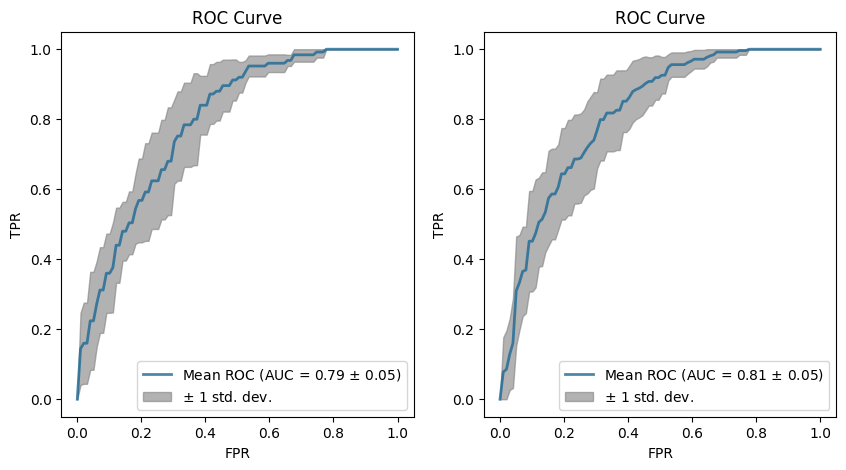

In [4]:
import matplotlib.pyplot as plt
from sklearn import metrics

fig, axs = plt.subplots(1,2, figsize=(10,5))

tprs = []
aucs = []
mean_fpr = np.linspace(0,1,100)

ax0 = axs[0]
for i in range(1,6):
    df = pd.read_csv(os.path.join(DATAPATH, "train_test_splits", "osm_test{}_1.csv".format(i)))
    out = pd.read_csv(os.path.join(DATAPATH, "zairachem_results", "output_test{}_1.csv".format(i)))
    yt = df["bin"]
    proba1 = out["clf_ex1"]
    fpr, tpr, _ = metrics.roc_curve(yt, proba1)
    roc_auc = metrics.roc_auc_score(yt, proba1)
    interp_tpr = np.interp(mean_fpr, fpr, tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(roc_auc)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = metrics.auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax0.plot(
    mean_fpr,
    mean_tpr,
    color="#1D6996",
    label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
    lw=2,
    alpha=0.8
)
std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax0.fill_between(
    mean_fpr,
    tprs_lower,
    tprs_upper,
    color="grey",
    alpha=0.6,
    label=r"$\pm$ 1 std. dev.",
    )
ax0.set(
    xlim=[-0.05, 1.05],
    ylim=[-0.05, 1.05],
    title = "ROC Curve",
    xlabel = "FPR",
    ylabel="TPR"
    )
ax0.legend(loc="lower right")

ax1 = axs[1]
for i in range(1,6):
    df = pd.read_csv(os.path.join(DATAPATH, "train_test_splits", "osm_test{}_25.csv".format(i)))
    out = pd.read_csv(os.path.join(DATAPATH, "zairachem_results", "output_test{}_25.csv".format(i)))
    yt = df["bin"]
    proba1 = out["clf_ex1"]
    fpr, tpr, _ = metrics.roc_curve(yt, proba1)
    roc_auc = metrics.roc_auc_score(yt, proba1)
    interp_tpr = np.interp(mean_fpr, fpr, tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(roc_auc)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = metrics.auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax1.plot(
    mean_fpr,
    mean_tpr,
    color="#1D6996",
    label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
    lw=2,
    alpha=0.8
)
std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax1.fill_between(
    mean_fpr,
    tprs_lower,
    tprs_upper,
    color="grey",
    alpha=0.6,
    label=r"$\pm$ 1 std. dev.",
    )
ax1.set(
    xlim=[-0.05, 1.05],
    ylim=[-0.05, 1.05],
    title = "ROC Curve",
    xlabel = "FPR",
    ylabel="TPR"
    )
ax1.legend(loc="lower right")

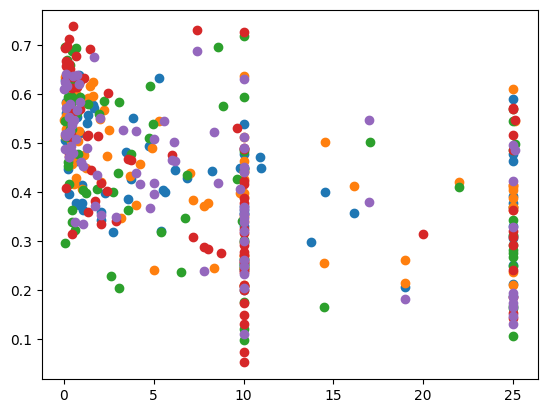

In [6]:
import matplotlib.pyplot as plt
fig,ax = plt.subplots(1,1)

cutoff = 25

for i in range(1,6):
    out = pd.read_csv(os.path.join(DATAPATH, "zairachem_results", "output_test{}_{}.csv".format(i, cutoff)))
    df = pd.read_csv(os.path.join(DATAPATH, "train_test_splits", "osm_test{}_{}.csv".format(i, cutoff)))
    yt = df["activity"]
    proba1 = out["clf_ex1"]
    ax.scatter(yt, proba1)